## 🤩 Initialization


In [ ]:
# g drive connect
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive/My Drive/HW2

In [ ]:
# !pip install, if needed

In [ ]:
# imports
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# Librerie per classi
from tensorflow.keras.layers import Layer, Concatenate, Input
from tensorflow.keras.models import Model
from keras.saving import register_keras_serializable
from tensorflow.keras.utils import register_keras_serializable

In [ ]:
# random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# dataset
data = np.load("data.npz")
# separate training+val (labelled) and test (unlabelled)
training_val_test_set = data["training_set"] # training set + validation set
X_test_kaggle = data["test_set"] # kaggle test set
# divide images and labels in training+val
X_train_val_test = training_val_test_set[:, 0]
y_train_val_test = training_val_test_set[:, 1]
# normalize all images. both training+val (labelled) and test (unlabelled)
X_train_val_test = X_train_val_test[..., np.newaxis] / 255.0
X_test_kaggle = X_test_kaggle[..., np.newaxis] / 255.0
# compute problem parameters
input_shape = X_train_val_test.shape[1:]
num_classes = len(np.unique(y_train_val_test))
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")
# divide training and val
X_train_val, X_test, y_train_val, y_test = train_test_split(X_train_val_test, y_train_val_test, random_state=seed, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1)
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")

Input shape: (64, 128, 1)
Number of classes: 5
Training X shape: (2117, 64, 128, 1)
Training y shape: (2117, 64, 128)
Validation X shape: (236, 64, 128, 1)
Validation y shape: (236, 64, 128)


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [ ]:
print(X_train.min(),X_train.max())

0.00784313725490196 0.996078431372549


In [ ]:
@register_keras_serializable()
class AdaptiveThresholdingLayer(tf.keras.layers.Layer):
    def __init__(self, block_size=11, c=2, print_flag=False, **kwargs):
        """
        Adaptive Thresholding Layer
        Args:
            block_size: Size of the neighborhood used to calculate the local threshold (must be odd).
            c: Constant subtracted from the local mean.
            print_flag: Flag to print input shapes for debugging.
        """
        super(AdaptiveThresholdingLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.c = c
        self.print_flag = print_flag  # Assegna il valore di print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)

        # Calcola la media locale
        mean_filter = tf.nn.avg_pool2d(inputs, ksize=self.block_size, strides=1, padding="SAME")

        # Thresholding adattivo: immagine binaria basata > C
        thresholded = tf.where(inputs >  self.c, tf.ones_like(inputs), tf.zeros_like(inputs))

        if self.print_flag:
            print("Thresholded output shape:", thresholded.shape)

        return thresholded

    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "c": self.c, "print_flag": self.print_flag})
        return config

In [ ]:
# Edge detection layer
@register_keras_serializable()
class EdgeDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, print_flag=False, **kwargs):
        super(EdgeDetectionLayer, self).__init__(**kwargs)
        self.print_flag = print_flag  # Assegna print_flag come attributo della classe

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)

        # Sobel filter for edge detection (applicato su un'immagine in formato [batch_size, height, width, channels])
        sobel_x = tf.image.sobel_edges(inputs)[..., 0]
        sobel_y = tf.image.sobel_edges(inputs)[..., 1]
        edges = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))  # Magnitude of gradient
        return edges

    def get_config(self):
        config = super().get_config()
        config.update({"print_flag": self.print_flag})  # Includi print_flag nella configurazione
        return config

In [ ]:
# Laplacian Layer
@register_keras_serializable()
class LaplacianLayer(tf.keras.layers.Layer):
    def __init__(self,print_flag=False, **kwargs):
        super(LaplacianLayer, self).__init__(**kwargs)
        self.print_flag = print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)


        # Calcola il kernel laplaciano
        laplacian_kernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)
        laplacian_kernel = laplacian_kernel[:, :, tf.newaxis, tf.newaxis]  # (3, 3, 1, 1)
        laplacian = tf.nn.conv2d(inputs, laplacian_kernel, strides=1, padding="SAME")
        return laplacian

    def get_config(self):
        return super().get_config()

Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresholded output shape: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresholded output shape: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresholded output shape: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Thresholded output shape: (1, 64, 128, 1)
Input shape before: (1, 64, 128, 1, 1)
Input shape after: (1, 64, 128, 1)
Input shape before

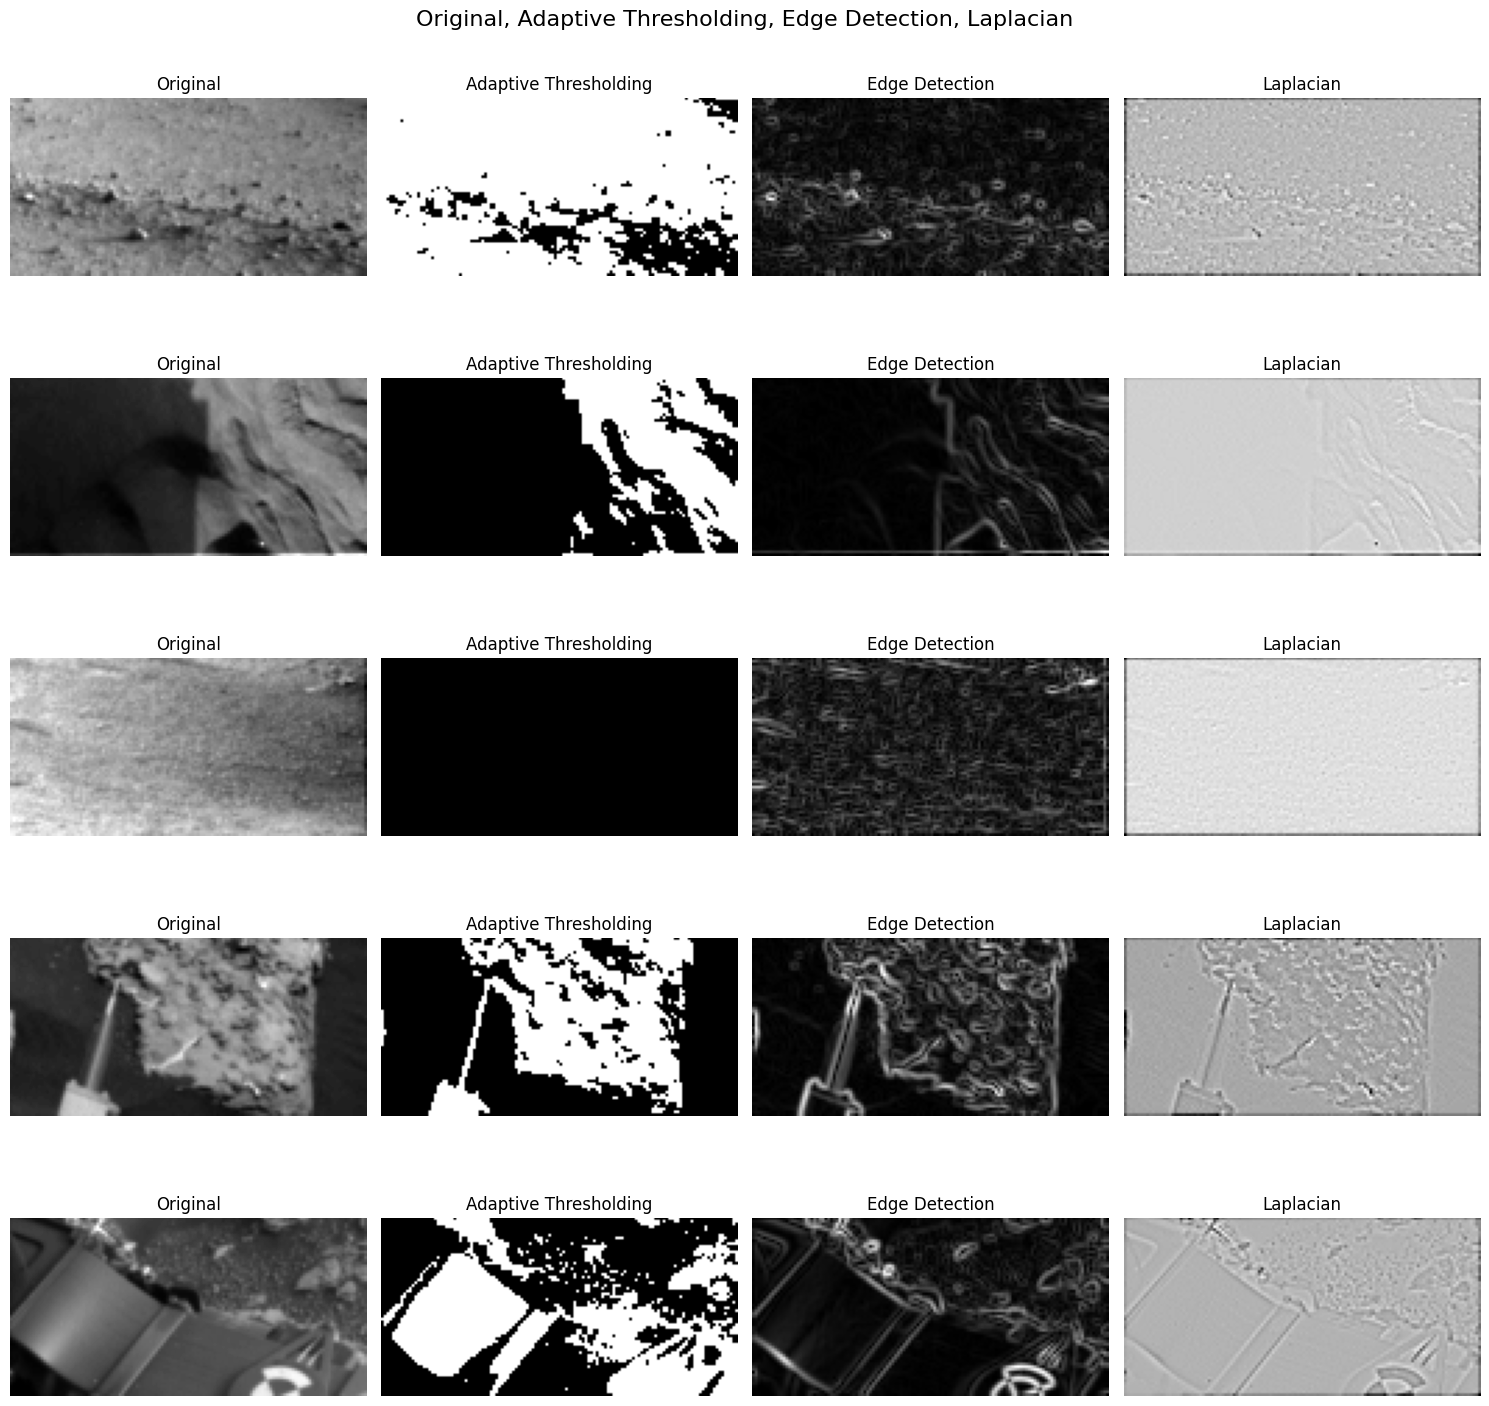

In [ ]:
# Funzione per visualizzare 5 immagini casuali per ciascun layer
def visualize_transformations(X_train, adaptive_threshold_layer, edge_layer, laplacian_layer):
    # Seleziona 5 indici casuali
    random_indices = np.random.choice(len(X_train), size=5, replace=False)
    selected_images = X_train[random_indices]

    # Prepara il layout per le immagini
    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    fig.suptitle("Original, Adaptive Thresholding, Edge Detection, Laplacian", fontsize=16)

    for i, img in enumerate(selected_images):
        img = img[np.newaxis, ..., np.newaxis]  # Aggiunge batch e channel dimension

        # Applica i layer custom
        adaptive_thresholded = adaptive_threshold_layer(img).numpy().squeeze()
        edges = edge_layer(img).numpy().squeeze()
        laplacian = laplacian_layer(img).numpy().squeeze()

        # Visualizza immagini
        axes[i, 0].imshow(img.squeeze(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(adaptive_thresholded, cmap='gray')
        axes[i, 1].set_title("Adaptive Thresholding")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(edges, cmap='gray')
        axes[i, 2].set_title("Edge Detection")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(laplacian, cmap='gray')
        axes[i, 3].set_title("Laplacian")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


# Array di esempio: X_train deve essere già caricato
# Supponendo che X_train abbia dimensioni (n_samples, 64, 128, 1)
adaptive_threshold_layer = AdaptiveThresholdingLayer(block_size=15, c=0.2,print_flag=True)
edge_layer = EdgeDetectionLayer(print_flag=True)
laplacian_layer = LaplacianLayer(print_flag=True)

# Visualizzazione delle trasformazioni
visualize_transformations(X_train, adaptive_threshold_layer, edge_layer, laplacian_layer)

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:

# Definizione dei tuoi custom layer, presupponendo che siano già stati implementati:
# AdaptiveThresholdingLayer, EdgeDetectionLayer, LaplacianLayer, e unet_block

def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Applicazione dei custom layers
    threshold_output = AdaptiveThresholdingLayer()(inputs)
    edge_output = EdgeDetectionLayer()(inputs)
    laplacian_output = LaplacianLayer()(inputs)

    # Concatenazione dell'input originale con le uscite dei custom layers
    concatenated = tfkl.Concatenate(axis=-1)([inputs, threshold_output, edge_output, laplacian_output])

    print("Shape of inputs:", inputs.shape)
    print("Shape of threshold_output:", threshold_output.shape)
    print("Shape of edge_output:", edge_output.shape)
    print("Shape of laplacian_output:", laplacian_output.shape)
    print("Shape after concatenation:", concatenated.shape)


    # Downsampling path
    down_block_1 = unet_block(concatenated, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    print("Downsampling block 1 shape:", down_block_1.shape)
    print("Downsampling block 2 shape:", down_block_2.shape)
    print("Bottleneck shape:", bottleneck.shape)
    print("Upsampling block 1 shape:", u1.shape)
    print("Upsampling block 2 shape:", u2.shape)


    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    # Costruzione del modello
    model = Model(inputs=inputs, outputs=output_layer, name='UNet')
    return model


Shape of inputs: (None, 64, 128, 1)
Shape of threshold_output: (None, 64, 128, 1)
Shape of edge_output: (None, 64, 128, 1)
Shape of laplacian_output: (None, 64, 128, 1)
Shape after concatenation: (None, 64, 128, 4)
Downsampling block 1 shape: (None, 64, 128, 32)
Downsampling block 2 shape: (None, 32, 64, 64)
Bottleneck shape: (None, 16, 32, 128)
Upsampling block 1 shape: (None, 32, 64, 64)
Upsampling block 2 shape: (None, 64, 128, 32)


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ adaptive_thresholding… │ (None, 64, 128, 1)   │            0 │ input_layer[0][0]   │    -    │
│ (AdaptiveThresholding… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ edge_detection_layer_1 │ (None, 64, 128, 1)   │            0 │ input_layer[0][0]   │    -    │
│ (EdgeDetectionLayer)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ laplacian_layer_1      │ (None, 64, 128, 1)   │            0 │ input_layer[0][0]   │    -    │
│ (LaplacianLayer)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ concatenate            │ (None, 64, 128, 4)   │            0 │ input_layer[0][0],  │    -    │
│ (Concatenate)          │                      │              │ adaptive_threshold… │         │
│                        │                      │              │ edge_detection_lay… │         │
│                        │                      │              │ laplacian_layer_1[… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │        1,184 │ concatenate[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1    

 Total params: 474,533 (1.81 MB)

 Trainable params: 473,253 (1.81 MB)

 Non-trainable params: 1,280 (5.00 KB)

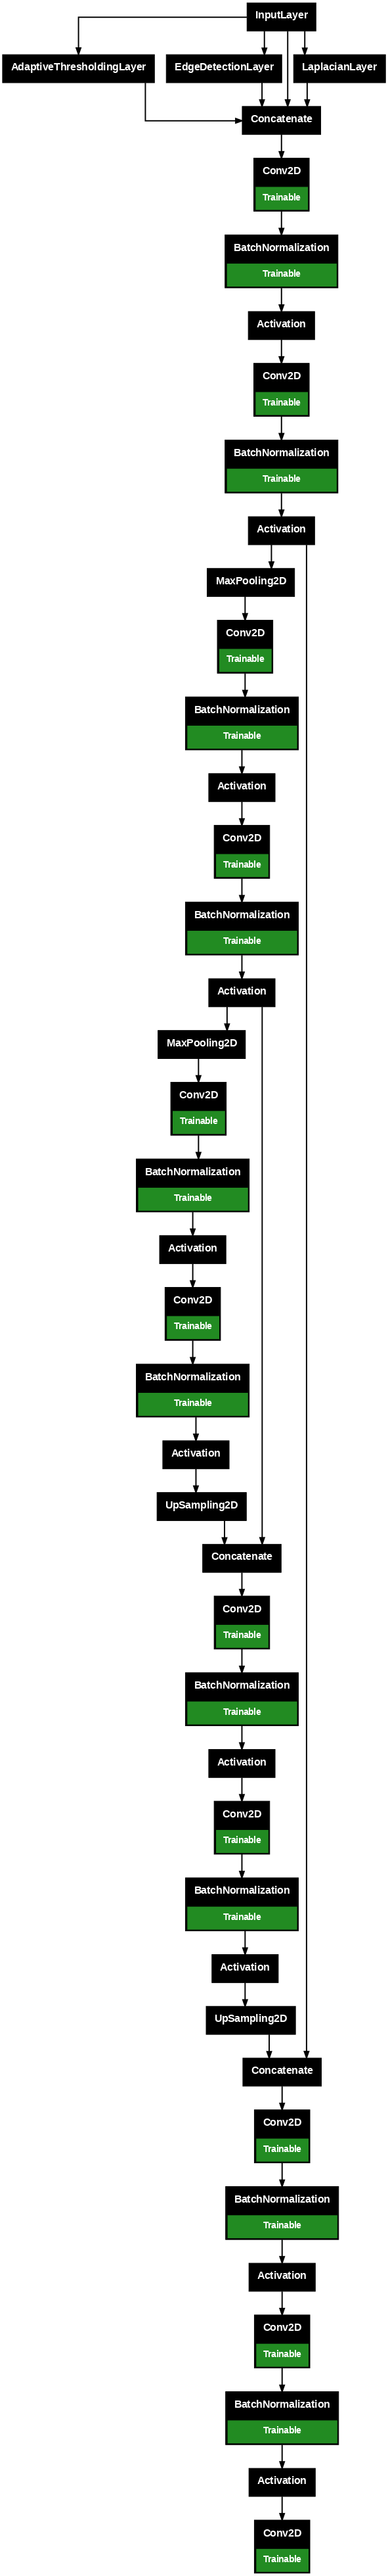

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
# Define the MeanIoU ignoring the background class
# mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

# Custom Version
import tensorflow as tf

@register_keras_serializable(package="Custom", name="CustomMeanIoU")
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_class=None, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.iou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Convert probabilities to class indices
        y_true = tf.cast(y_true, tf.int32)

        # Ignore the specified class
        if self.ignore_class is not None:
            mask = tf.not_equal(y_true, self.ignore_class)  # Filter out the ignored class
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        self.iou_metric.update_state(y_true, y_pred)

    def result(self):
        return self.iou_metric.result()

    def reset_states(self):
        self.iou_metric.reset_states()

    def get_config(self):
        """Serialize the configuration of the metric."""
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "ignore_class": self.ignore_class,
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstruct the metric from its config."""
        return cls(**config)


In [ ]:
mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,clipnorm=1.0),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

In [ ]:
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if logs['loss'] == float('nan'):
            print(f"NaN detected at batch {batch}")
            self.model.stop_training = True

In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    verbose=1
).history

Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4684 - loss: 1.2790 - mean_iou: 0.2458 - val_accuracy: 0.2163 - val_loss: 1.6851 - val_mean_iou: 0.0573
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.6041 - loss: 1.0165 - mean_iou: 0.3354 - val_accuracy: 0.2242 - val_loss: 1.7431 - val_mean_iou: 0.0184
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6256 - loss: 0.9548 - mean_iou: 0.3493 - val_accuracy: 0.3006 - val_loss: 2.1333 - val_mean_iou: 0.0804
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.6484 - loss: 0.9071 - mean_iou: 0.3670 - val_accuracy: 0.2405 - val_loss: 2.4805 - val_mean_iou: 0.0055
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6542 - loss: 0.8876 - mean_iou: 0.3695 - val_accuracy: 0.2387 - val_loss: 2.7170 - val_mean_iou: 5.2221e-04
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6661 - loss: 0.8574 - mean_iou: 0.3794 - val_accuracy: 0.2473 - val_l

In [ ]:
print(np.unique(y_train))  # Controlla se ci sono classi mancanti

[0. 1. 2. 3. 4.]


In [ ]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_'+str(sub_number)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 44.95%


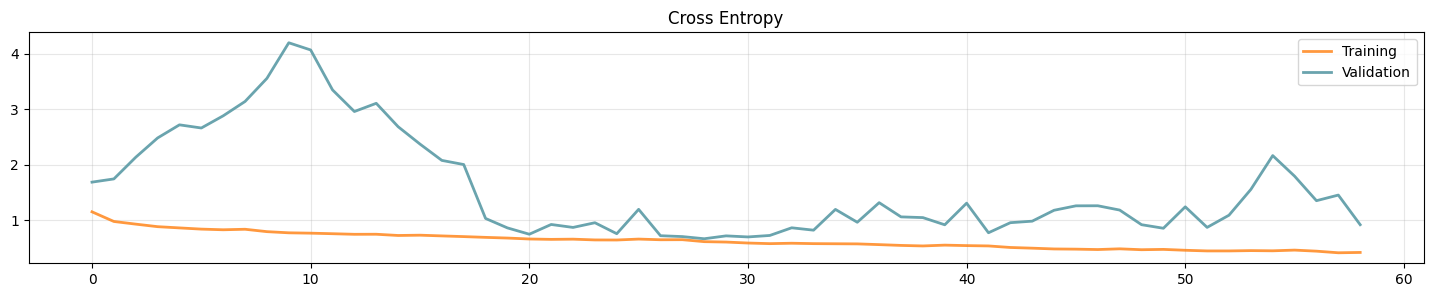

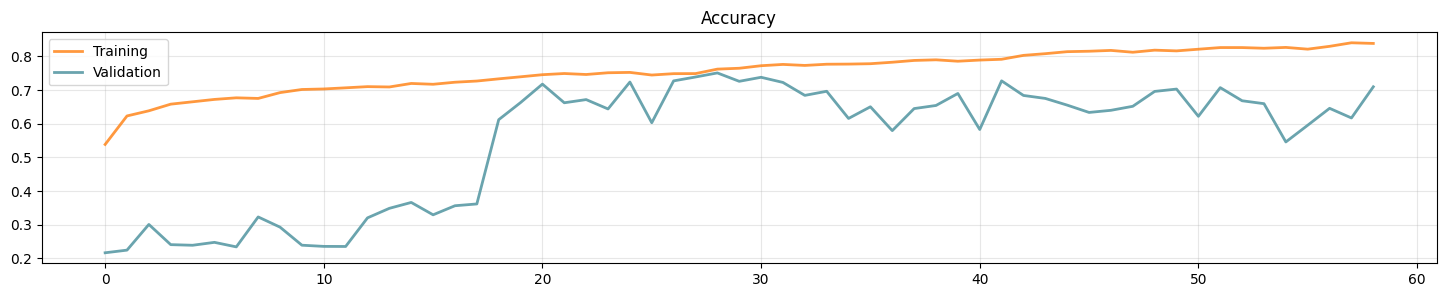

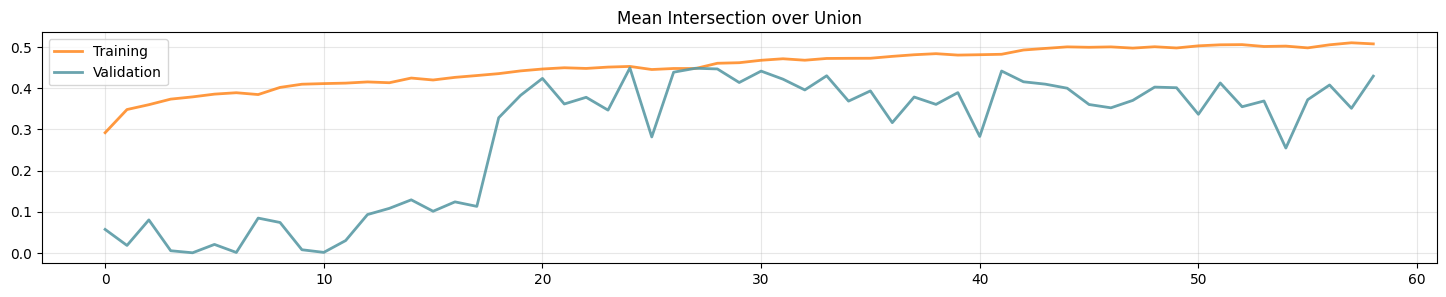

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model('model_'+str(sub_number)+'.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", mean_iou]
)

In [ ]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(
    X_test, y_test, verbose=0, batch_size=10
)
print(f'Test Loss: {round(test_loss, 4)}')
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Loss: 0.7233
Test Accuracy: 0.7156
Test Mean Intersection over Union: 0.4268


In [ ]:
model_filename = f"model_after_test_{sub_number}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_after_test_3.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_after_test_3.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 86 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
preds = model.predict(X_test_kaggle)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission_filename)

submission_after_test_3.csv
